# **Lab 5: Feature Extraction From Images and Robust Fitting**
# **(Part I)**

---

In many real-world computer vision tasks — such as object recognition, image stitching (the process of combining multiple photographic images with overlapping fields of view) — we need to identify reliable points in images that can be detected consistently, even when the scene changes slightly (e.g., different viewpoints, lighting, or noise). Edges alone are often too fragile for these tasks. Corners, on the other hand, are stronger, more distinctive, and easier to match across images.

This lab will guide you through detecting and extracting robust local features (corners), fitting geometric models robustly even in the presence of noise (using RANSAC), and taking the first steps toward feature-based image matching. You will explore different methods for feature detection, compare line fitting techniques under noise, and practice simple patch-based matching across images.


By the end of this lab, students will be able to:

1. Detect and visualize corners using the Harris Corner Detector.

2. Fit lines to noisy data using least squares, Hough Transform, and RANSAC, and compare their robustness.

3. Perform simple feature matching between images using local patch similarity.

4. Understand the impact of noise, parameter tuning, and robustness in feature extraction and model fitting.



### **Quick Recap of Previous Lab**

1. What are edges? Edges are locations in an image where there is a sudden change in intensity or color, often corresponding to object boundaries, textures, or important structures in a scene.

2. Post-processing using morphology: After detecting edges, morphological operations like dilation, erosion, opening, and closing were applied to clean up the edge maps for example, to remove noise, fill gaps, or connect broken edges.

3. Hough Transform: The Hough Transform was used to detect global shapes (lines, circles) by voting in a parameter space. It can identify structures even if the edge map is noisy or incomplete.


### **Connection to Today's Lab**


In the previous lab, we focused on detecting and enhancing edges, important low-level features that highlight object boundaries and shapes.
Today, we take the next step: instead of working only with edges, we will extract more distinctive features, such as corners, which are more stable and repeatable across different views.

We will also learn how to robustly fit models in the presence of noise and outliers, and begin building towards matching features between different images, a fundamental capability in many computer vision systems.


### Understanding the libraries used
Before starting the lab, provide a brief definition of the following libraries and their role in image processing:

- **OpenCV**: Open Source Computer Vision Library, primarily used for image and video processing tasks such as geometric transformations, filtering, and morphological operations.
  
- **NumPy**: A fundamental package for numerical computing in Python, providing support for arrays, matrices, and mathematical functions used in image processing.
  
- **Matplotlib**: A plotting library for Python that enables visualization of images, histograms, and transformations applied to images.

If not installed, you can install them using:

`pip install opencv-python numpy matplotlib`

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Manipulation 1: Detecting Object Corners Within Images

## Task 1: Harris Corner Detection
In this task, you will explore the detection of corners, highly distinctive points in an image that are robust to transformations like rotation and slight changes in viewpoint.

You will apply the Harris Corner Detection algorithm, tune its parameters, and visualize the results.
This will help you understand how feature detection differs from simple edge detection, and why corners are more reliable for tasks like matching and recognition.


![Harris Corner Detection](./Illustrations/harris.jpg)


#### **T1.1: Harris Corner Detection Using OpenCV**

- Objective: Detect and visualize corners in an image using the Harris Corner Detection method.

- Procedure:
    1. Choose an image from the Images folder.
    1. Transform your image into the grayscale.
    2. Apply the Harris Corner Detection using OpenCV’s cv2.cornerHarris() function.
    3. Tune the parameters:

        - **Threshold on corner response:** Set a threshold to select significant corners. Try different values to see how many and what quality of corners are detected.

        - **Window size (blockSize in OpenCV):** The size of the neighborhood around each pixel used for computing the corner response. Common values to test include 3x3, 5x5, and 7x7.

        - **Aperture parameter (ksize in OpenCV):** The size of the Sobel kernel used to compute image gradients. Test different values such as 3, 5, and 7 for this parameter.


        - **Sensitivity parameter (k in OpenCV):** A factor that influences the sensitivity of corner detection. This parameter is usually between 0.04 and 0.06. Test different values to see how they affect the corner detection results.

    4. Visualize detected corners over the original images for different settings (side-by-side if possible).

### **Questions**

- How do the parameters (window size, sensitivity factor k) influence the quality and number of detected corners ?
- On which images do you get the most reliable corner detection ?

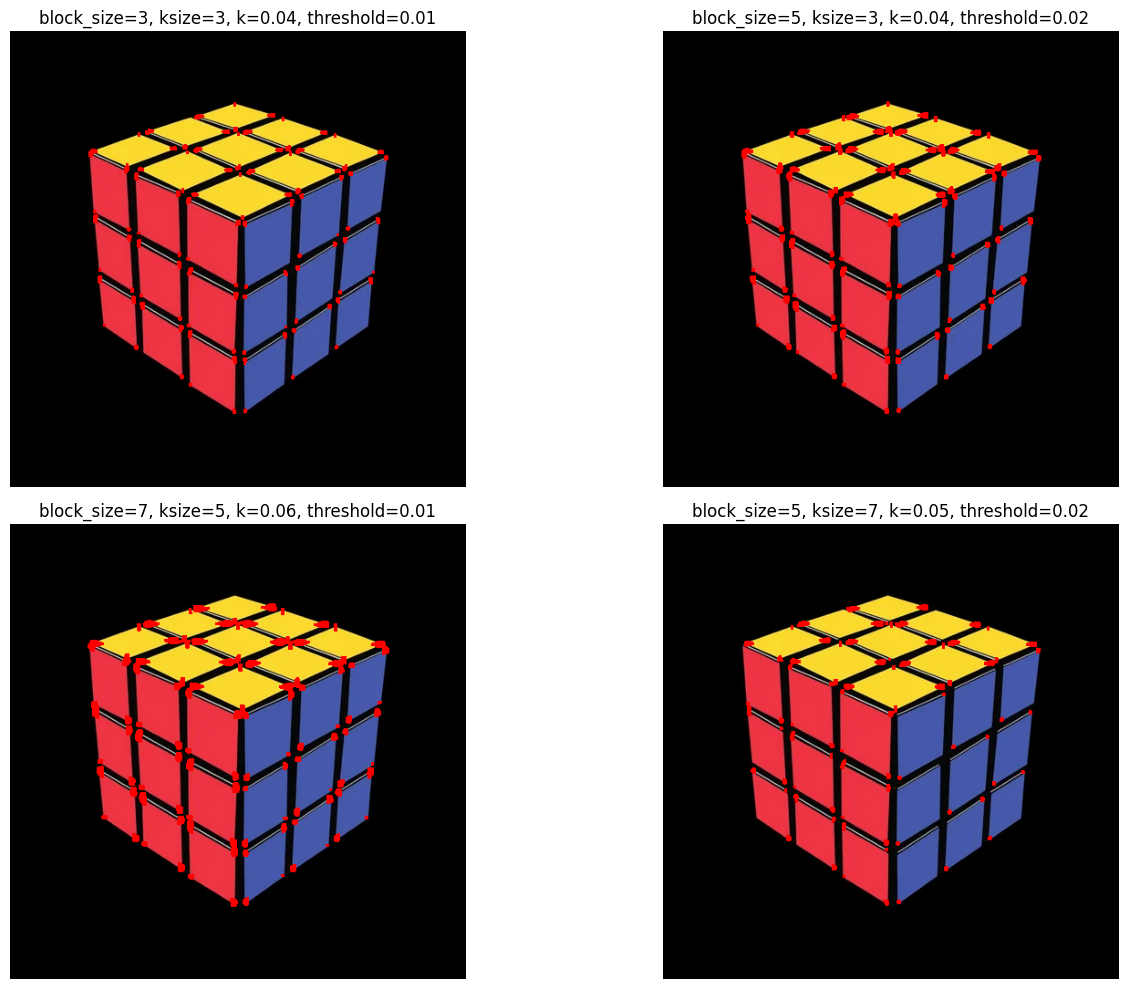

In [ ]:

# Load the image
image = cv2.imread('Images/rubiks-cube-500x500.png') 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  

# Define parameter sets for Harris Corner Detection
parameter_sets = [
    {"block_size": 3, "ksize": 3, "k": 0.04, "threshold": 0.01},
    {"block_size": 5, "ksize": 3, "k": 0.04, "threshold": 0.02},
    {"block_size": 7, "ksize": 5, "k": 0.06, "threshold": 0.01},
    {"block_size": 5, "ksize": 7, "k": 0.05, "threshold": 0.02},
]

# Visualize results for each parameter set
plt.figure(figsize=(15, 10))
for i, params in enumerate(parameter_sets):
    # Apply Harris Corner Detection
    corner_response = cv2.cornerHarris(
        gray, blockSize=params["block_size"], ksize=params["ksize"], k=params["k"]
    )
    corner_response = cv2.dilate(corner_response, None)  

    # Mark corners on the original image
    image_with_corners = image.copy()
    image_with_corners[corner_response > params["threshold"] * corner_response.max()] = [0, 0, 255]  

    # Plot the result
    plt.subplot(2, 2, i + 1)
    plt.title(
        f"block_size={params['block_size']}, ksize={params['ksize']}, k={params['k']}, threshold={params['threshold']}"
    )
    plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()

**Add your analysis and comments here**

### Analysis:

1. **Influence of Parameters:**
   - **Window Size (`block_size`)**: Increasing the window size results in a broader neighborhood for corner detection. Smaller values (e.g., `block_size=3`) detect more corners, but they may include noise or less significant features. Larger values (e.g., `block_size=7`) focus on more prominent corners but may miss finer details.
   - **Aperture Parameter (`ksize`)**: This controls the size of the Sobel kernel used for gradient computation. Smaller values (e.g., `ksize=3`) detect sharper corners, while larger values (e.g., `ksize=7`) smooth the gradients, potentially missing some corners.
   - **Sensitivity Factor (`k`)**: Lower values (e.g., `k=0.04`) are more sensitive and detect more corners, but they may include false positives. Higher values (e.g., `k=0.06`) are stricter, detecting fewer but more reliable corners.
   - **Threshold**: A lower threshold (e.g., `threshold=0.01`) highlights more corners, including weaker ones. A higher threshold (e.g., `threshold=0.02`) filters out weaker corners, leaving only the strongest responses.

2. **Most Reliable Corner Detection:**
   - The most reliable corner detection occurs with balanced parameter settings, such as `block_size=5`, `ksize=3`, `k=0.04`, and `threshold=0.02`. These settings detect significant corners while avoiding excessive noise or false positives.
   - Images with clear, well-defined edges (e.g., the Rubik's cube) yield the most reliable results, as the corners are distinct and easily detectable.


# Manipulation 2: Robust Line Fitting under Noise and Outliers

![Line fitting](./Illustrations/line_fitting.jpg)

In this manipulation, you will explore and compare different line fitting techniques that can be applied to datasets corrupted by noise and outliers.
Specifically, you will investigate:

- Standard Least Squares fitting (sensitive to outliers),

- Hough Transform (detecting lines in binary images),

- RANSAC (robust estimation despite heavy noise).

You will generate synthetic datasets and analyze how each method performs as the proportion of noise and outliers increases.



## **Task 1 : Polyfitting with Least Squares**

In this task, you will focus on line fitting using the Least Squares method.
You will generate synthetic data, apply polynomial fitting (degree 1 and higher), and study the sensitivity of the fitting to noise and outliers.

This task highlights the limitations of standard fitting when no explicit outlier handling is performed.

#### **T1.1: Synthetic Data Generation**

- Objective: Generate a noisy dataset for line fitting:

    - Create points lying along a line (with small random noise).
    - Add many random points as outliers (distributed in the 2D plane).

- Procedure:
    1. Create a dataset with a tunable percentage of inliers and outliers (e.g., 70% inliers, 30% outliers).
    2. Visualize the resulting dataset using a scatter plot.


### **Questions**

- How does the proportion of outliers affect the visual separability of the inlier line?
- Can you visually distinguish the true line when outliers are very dense?

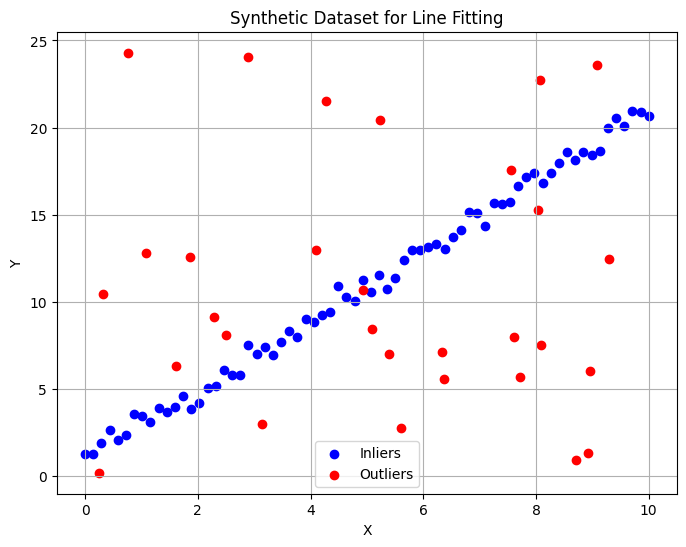

In [4]:
#Your Code Here...

# Generate synthetic data
np.random.seed(42)  # For reproducibility
num_points = 100
inlier_ratio = 0.7
num_inliers = int(num_points * inlier_ratio)
num_outliers = num_points - num_inliers

# Generate inliers (points along a line with small noise)
x_inliers = np.linspace(0, 10, num_inliers)
y_inliers = 2 * x_inliers + 1 + np.random.normal(0, 0.5, num_inliers)  # y = 2x + 1 + noise

# Generate outliers (random points in the 2D plane)
x_outliers = np.random.uniform(0, 10, num_outliers)
y_outliers = np.random.uniform(0, 25, num_outliers)

# Combine inliers and outliers
x = np.concatenate([x_inliers, x_outliers])
y = np.concatenate([y_inliers, y_outliers])

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(x_inliers, y_inliers, color='blue', label='Inliers')
plt.scatter(x_outliers, y_outliers, color='red', label='Outliers')
plt.title("Synthetic Dataset for Line Fitting")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()


**Add your analysis and comments here**

### Answers:

1. **How does the proportion of outliers affect the visual separability of the inlier line?**  
   - As the proportion of outliers increases, the visual separability of the inlier line decreases. The inliers become harder to distinguish from the outliers, especially when the outliers are distributed close to or overlapping with the inlier line. This makes it challenging to visually identify the true line.

2. **Can you visually distinguish the true line when outliers are very dense?**  
   - When outliers are very dense, it becomes nearly impossible to visually distinguish the true line. The high density of outliers obscures the inlier pattern, making the line appear noisy or completely hidden within the scattered points.
...

#### **T1.2: Line Fitting without Outlier Rejection**


- Objective: Fit lines to the noisy dataset without explicitly handling outliers.


- Procedure:
    1. Fit a linear model (degree 1 polynomial) using np.polyfit().
    2. Fit a nonlinear model (degree 2 or 3 polynomial) and observe the behavior.
    3. Plot the fitted lines/curves over the noisy dataset.

### **Questions**

- How does the fitted model behave as the percentage of outliers increases?
- Is the linear model or the nonlinear model more robust to outliers in this case?


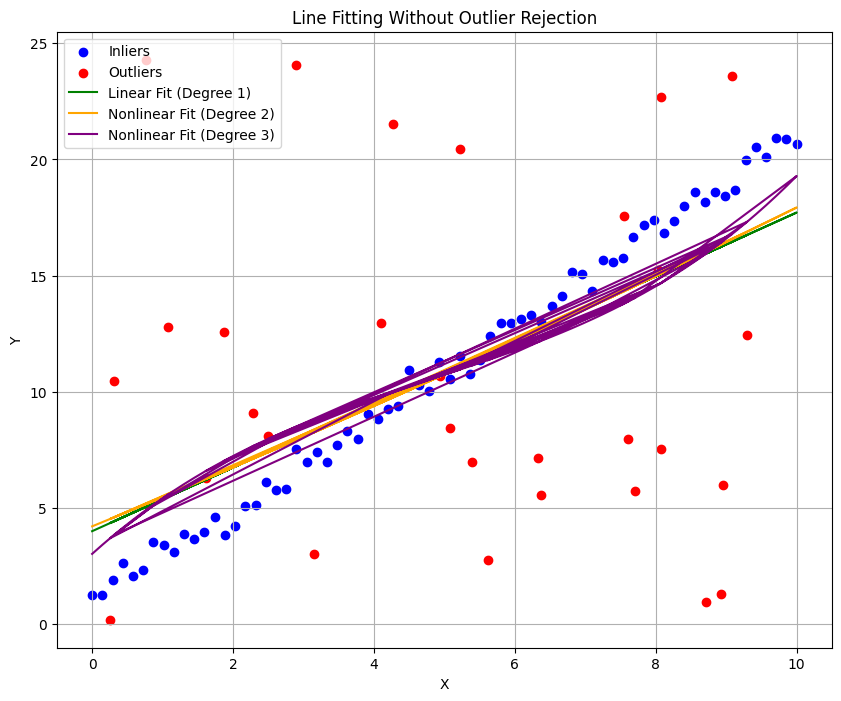

In [5]:
#Your Code Here...
# Fit a linear model (degree 1 polynomial)
linear_model = np.polyfit(x, y, 1)
linear_fit = np.poly1d(linear_model)

# Fit a nonlinear model (degree 2 polynomial)
nonlinear_model_deg2 = np.polyfit(x, y, 2)
nonlinear_fit_deg2 = np.poly1d(nonlinear_model_deg2)

# Fit a nonlinear model (degree 3 polynomial)
nonlinear_model_deg3 = np.polyfit(x, y, 3)
nonlinear_fit_deg3 = np.poly1d(nonlinear_model_deg3)

# Plot the dataset and the fitted models
plt.figure(figsize=(10, 8))
plt.scatter(x_inliers, y_inliers, color='blue', label='Inliers')
plt.scatter(x_outliers, y_outliers, color='red', label='Outliers')
plt.plot(x, linear_fit(x), color='green', label='Linear Fit (Degree 1)')
plt.plot(x, nonlinear_fit_deg2(x), color='orange', label='Nonlinear Fit (Degree 2)')
plt.plot(x, nonlinear_fit_deg3(x), color='purple', label='Nonlinear Fit (Degree 3)')
plt.title("Line Fitting Without Outlier Rejection")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()


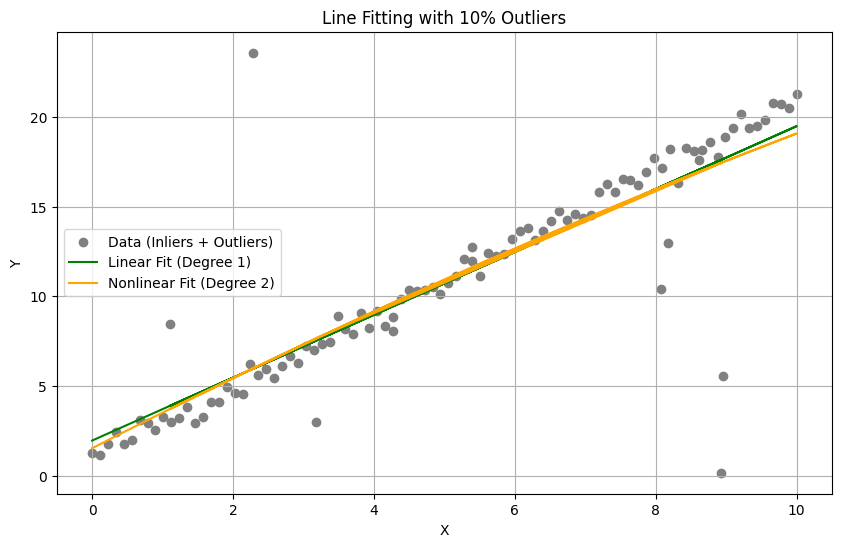

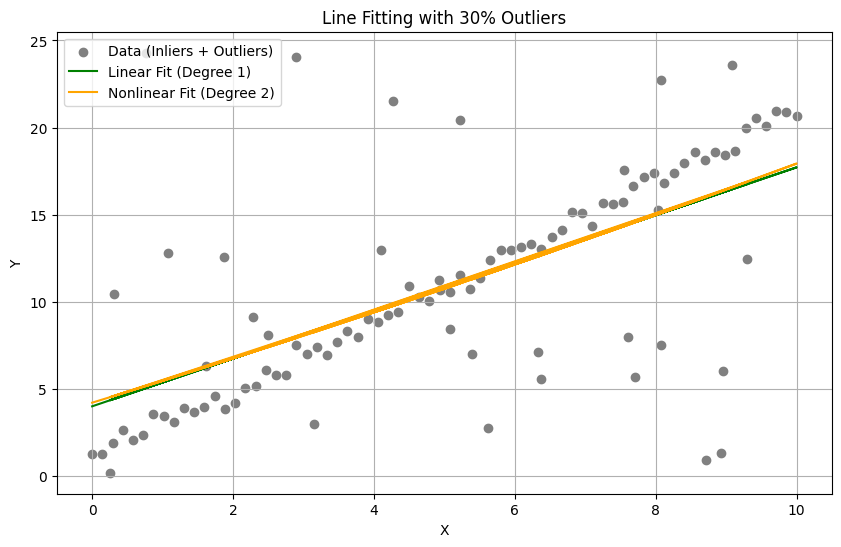

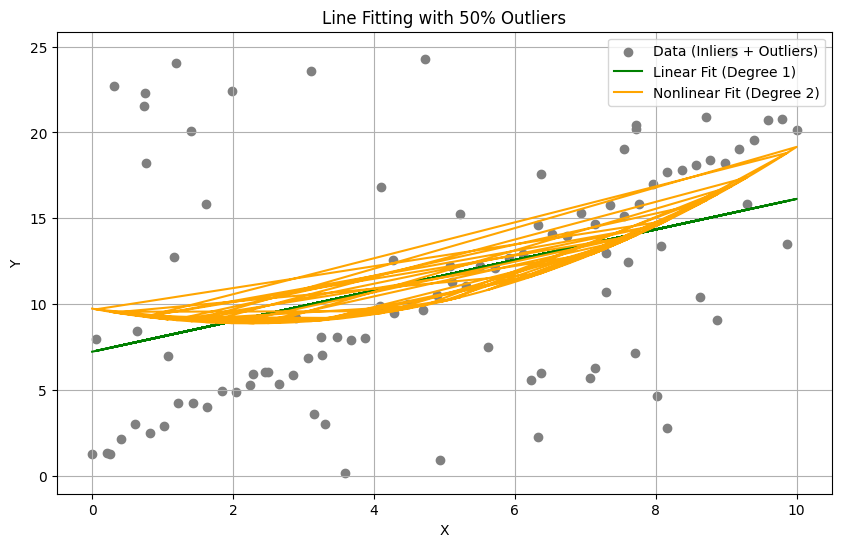

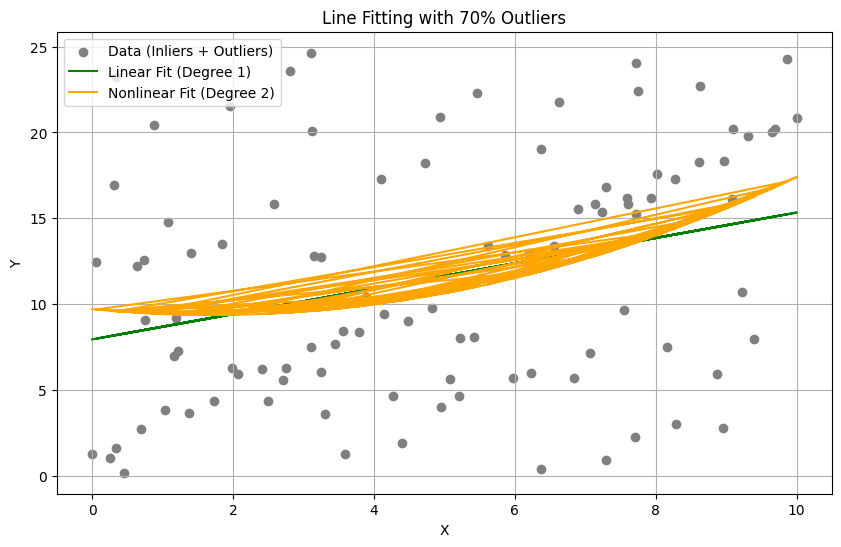

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate synthetic data with a given percentage of outliers
def generate_data(outlier_percentage):
    np.random.seed(42)  # For reproducibility
    num_points = 100
    num_inliers = int(num_points * (1 - outlier_percentage))
    num_outliers = num_points - num_inliers

    # Generate inliers (points along a line with small noise)
    x_inliers = np.linspace(0, 10, num_inliers)
    y_inliers = 2 * x_inliers + 1 + np.random.normal(0, 0.5, num_inliers)  # y = 2x + 1 + noise

    # Generate outliers (random points in the 2D plane)
    x_outliers = np.random.uniform(0, 10, num_outliers)
    y_outliers = np.random.uniform(0, 25, num_outliers)

    # Combine inliers and outliers
    x = np.concatenate([x_inliers, x_outliers])
    y = np.concatenate([y_inliers, y_outliers])

    return x, y

# Function to fit models and plot results
def fit_and_plot(outlier_percentage):
    x, y = generate_data(outlier_percentage)

    # Fit a linear model (degree 1 polynomial)
    linear_model = np.polyfit(x, y, 1)
    linear_fit = np.poly1d(linear_model)

    # Fit a nonlinear model (degree 2 polynomial)
    nonlinear_model_deg2 = np.polyfit(x, y, 2)
    nonlinear_fit_deg2 = np.poly1d(nonlinear_model_deg2)

    # Plot the dataset and the fitted models
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='gray', label='Data (Inliers + Outliers)')
    plt.plot(x, linear_fit(x), color='green', label='Linear Fit (Degree 1)')
    plt.plot(x, nonlinear_fit_deg2(x), color='orange', label='Nonlinear Fit (Degree 2)')
    plt.title(f"Line Fitting with {int(outlier_percentage * 100)}% Outliers")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function with different percentages of outliers
for outlier_percentage in [0.1, 0.3, 0.5, 0.7]:
    fit_and_plot(outlier_percentage)


### Answers:
1. **How does the fitted model behave as the percentage of outliers increases?**  
   - As the percentage of outliers increases, the linear model becomes less accurate and deviates significantly from the true line. The nonlinear model (degree 2) starts overfitting to the outliers, producing curves that do not represent the true underlying trend.

2. **Is the linear model or the nonlinear model more robust to outliers in this case?**  
   - The linear model is slightly more robust to outliers than the nonlinear model. The nonlinear model tends to overfit the outliers, especially as their percentage increases, while the linear model maintains a simpler fit, albeit still affected by the outliers.

#### **T1.3: Evaluation: Effect of Outliers**

- Objective: Quantitatively evaluate the robustness of fitting methods.

- Procedure: 

    1. Vary the percentage of outliers in the dataset (e.g., 0%, 20%, 30%... up to 90%) and perform the fitting for each case.

    2. For each fitting (linear and nonlinear):
        - Fit linear and nonlinear models.
        - compute the Mean Squared Error (MSE) between the predicted and true inlier points.

    3. Plot a graph showing MSE vs. Outlier Percentage for:
        - Linear fitting (degree 1)
        - Nonlinear fitting (degree 2 or more)

### **Questions:**

- Which model shows lower MSE at high outlier rates?
- What does the MSE trend tell you about each model’s sensitivity to noise?





C:\Users\Larbi\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


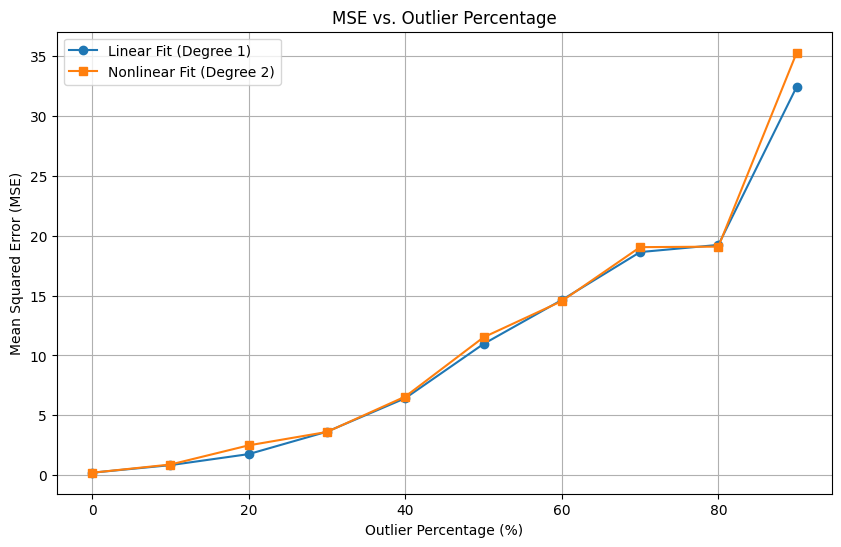

In [8]:
from sklearn.metrics import mean_squared_error

# Function to generate synthetic data with a given percentage of outliers
def generate_data(outlier_percentage):
    np.random.seed(42)  # For reproducibility
    num_points = 100
    num_inliers = int(num_points * (1 - outlier_percentage))
    num_outliers = num_points - num_inliers

    # Generate inliers (points along a line with small noise)
    x_inliers = np.linspace(0, 10, num_inliers)
    y_inliers = 2 * x_inliers + 1 + np.random.normal(0, 0.5, num_inliers)  # y = 2x + 1 + noise

    # Generate outliers (random points in the 2D plane)
    x_outliers = np.random.uniform(0, 10, num_outliers)
    y_outliers = np.random.uniform(0, 25, num_outliers)

    # Combine inliers and outliers
    x = np.concatenate([x_inliers, x_outliers])
    y = np.concatenate([y_inliers, y_outliers])

    return x, y, x_inliers, y_inliers

# Function to compute MSE for linear and nonlinear models
def compute_mse(outlier_percentage):
    x, y, x_inliers, y_inliers = generate_data(outlier_percentage)

    # Fit a linear model (degree 1 polynomial)
    linear_model = np.polyfit(x, y, 1)
    linear_fit = np.poly1d(linear_model)
    y_pred_linear = linear_fit(x_inliers)
    mse_linear = mean_squared_error(y_inliers, y_pred_linear)

    # Fit a nonlinear model (degree 2 polynomial)
    nonlinear_model = np.polyfit(x, y, 2)
    nonlinear_fit = np.poly1d(nonlinear_model)
    y_pred_nonlinear = nonlinear_fit(x_inliers)
    mse_nonlinear = mean_squared_error(y_inliers, y_pred_nonlinear)

    return mse_linear, mse_nonlinear

# Main function to vary outlier percentages and plot MSE
outlier_percentages = np.arange(0, 1.0, 0.1)  # 0% to 90% outliers
mse_linear_list = []
mse_nonlinear_list = []

for outlier_percentage in outlier_percentages:
    mse_linear, mse_nonlinear = compute_mse(outlier_percentage)
    mse_linear_list.append(mse_linear)
    mse_nonlinear_list.append(mse_nonlinear)

# Plot MSE vs. Outlier Percentage
plt.figure(figsize=(10, 6))
plt.plot(outlier_percentages * 100, mse_linear_list, label="Linear Fit (Degree 1)", marker='o')
plt.plot(outlier_percentages * 100, mse_nonlinear_list, label="Nonlinear Fit (Degree 2)", marker='s')
plt.title("MSE vs. Outlier Percentage")
plt.xlabel("Outlier Percentage (%)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()

Based on the MSE plot:


1. **Which model shows lower MSE at high outlier rates?**  
   - The **linear model (degree 1)** generally shows a lower MSE at high outlier rates compared to the nonlinear model (degree 2). This is because the nonlinear model tends to overfit the outliers, leading to higher errors.

2. **What does the MSE trend tell you about each model’s sensitivity to noise?**  
   - The **linear model** is less sensitive to noise and outliers, as it maintains a simpler fit and avoids overfitting.  
   - The **nonlinear model** is more sensitive to noise and outliers, as it tries to fit the data more closely, including the outliers, which increases the MSE significantly as the outlier percentage grows.

## **Task 2: Line Detection Using the Hough Transform and RANSAC**

#### **Task 2.1: Applying Hough Transform**

- **Objective:**  
  Detect lines using the Hough Transform on noisy datasets with varying levels of outliers.

- **Procedure:**

    1. Generate a synthetic dataset composed of points that approximately follow a line of the form *y = ax + b*, while progressively adding more outliers (e.g., 0%, 20%, 40%, 60%, 80%).

    2. Convert the points into a binary image (white points on a black background).
       - You can refer to an example in the `Images` folder (e.g., `binary_image.png`).

    3. Apply OpenCV’s `cv2.HoughLines()` function to detect lines in the binary image.

    4. Plot the detected lines over the original set of points for visual analysis.




![Line fitting](./Illustrations/hough_vs_ransac_1a.png)
![Line fitting](./Illustrations/hough_vs_ransac_1b.png)

---


![Line fitting](./Illustrations/hough_vs_ransac_2a.png)
![Line fitting](./Illustrations/hough_vs_ransac_2b.png)



### **Questions**

- How sensitive is the Hough Transform to its parameter settings (e.g., threshold)?

- What types of errors are typical with Hough Transform under heavy noise?

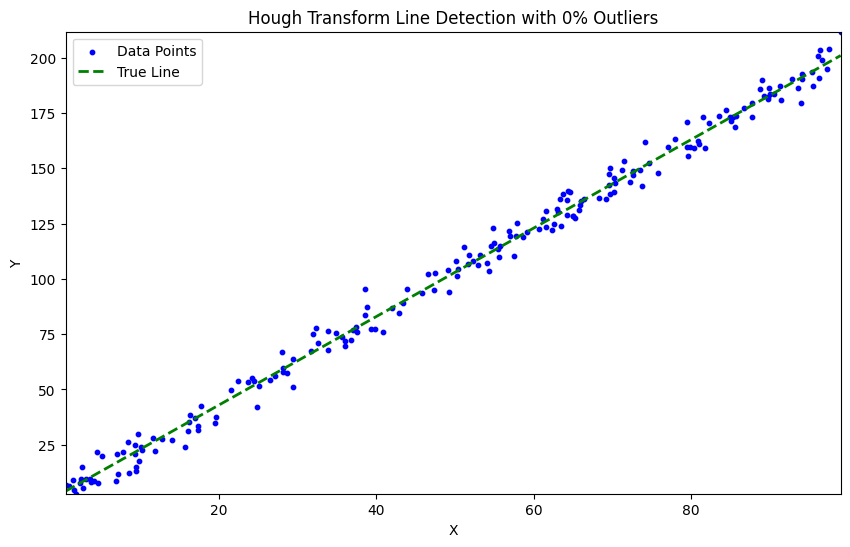

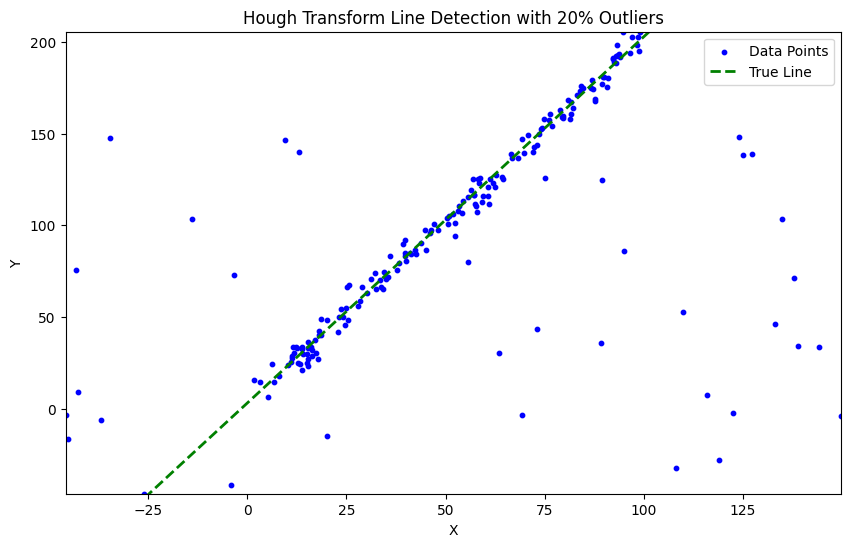

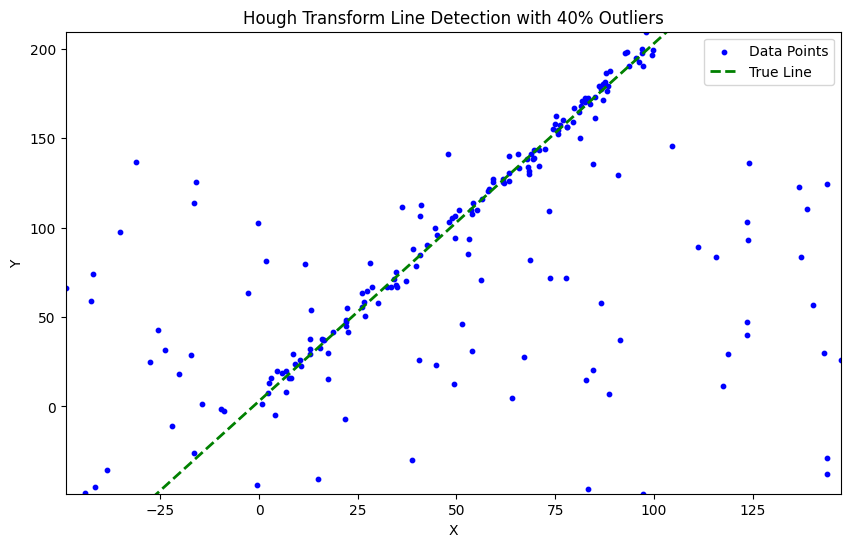

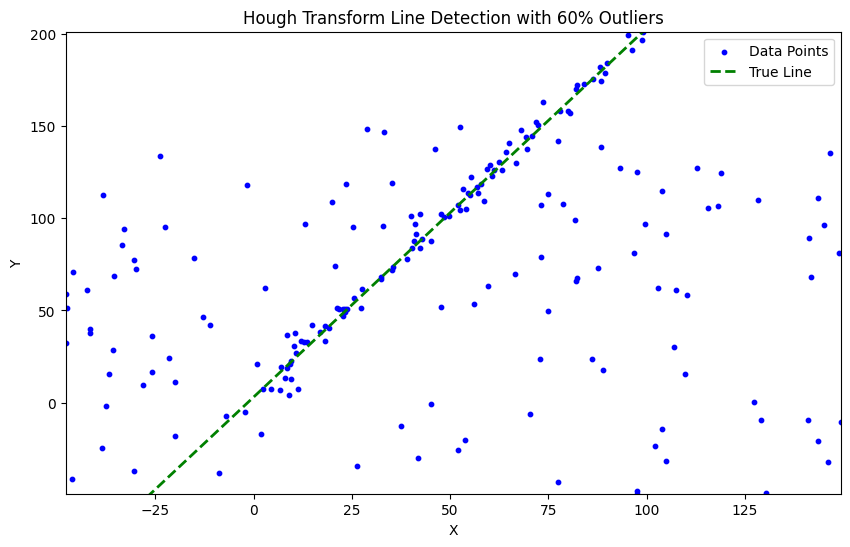

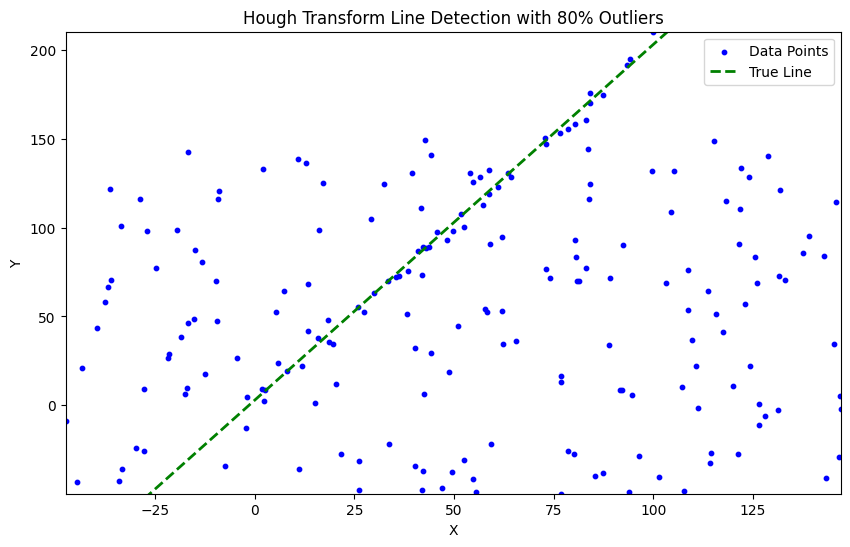

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_data(a=2, b=3, num_points=100, outlier_percent=0.2, noise_std=5):
    num_inliers = int(num_points * (1 - outlier_percent))
    num_outliers = num_points - num_inliers

    # Generate inliers
    x_inliers = np.random.uniform(0, 100, num_inliers)
    y_inliers = a * x_inliers + b + np.random.normal(0, noise_std, num_inliers)

    # Generate outliers
    x_outliers = np.random.uniform(-50, 150, num_outliers)
    y_outliers = np.random.uniform(-50, 150, num_outliers)

    # Combine data
    x = np.concatenate([x_inliers, x_outliers])
    y = np.concatenate([y_inliers, y_outliers])

    return x, y

def create_binary_image(x, y, image_size=500):
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)

    # Handle case where all points have the same x or y
    if x_max - x_min == 0:
        x_max += 1e-5
    if y_max - y_min == 0:
        y_max += 1e-5

    img = np.zeros((image_size, image_size), dtype=np.uint8)

    for xi, yi in zip(x, y):
        img_x = int(((xi - x_min) / (x_max - x_min)) * (image_size - 1))
        img_y = int(((yi - y_min) / (y_max - y_min)) * (image_size - 1))
        img[img_y, img_x] = 255

    return img, (x_min, x_max, y_min, y_max)

def detect_lines(img, num_inliers, rho=1, theta=np.pi/180):
    threshold = max(int(num_inliers * 0.5), 10)
    lines = cv2.HoughLines(img, rho, theta, threshold)
    return lines

def convert_line_to_data_coordinates(line, x_min, x_max, y_min, y_max, image_size=500):
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    x1_img, y1_img = pt1
    x2_img, y2_img = pt2

    x1_data = x_min + (x1_img / (image_size - 1)) * (x_max - x_min)
    y1_data = y_min + (y1_img / (image_size - 1)) * (y_max - y_min)
    x2_data = x_min + (x2_img / (image_size - 1)) * (x_max - x_min)
    y2_data = y_min + (y2_img / (image_size - 1)) * (y_max - y_min)

    return (x1_data, y1_data), (x2_data, y2_data)

def plot_results(x, y, lines, x_min, x_max, y_min, y_max, a, b, outlier_percent, image_size=500):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='b', s=10, label='Data Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Hough Transform Line Detection with {int(outlier_percent*100)}% Outliers')

    # Plot true line
    x_gt = np.array([x_min, x_max])
    y_gt = a * x_gt + b
    plt.plot(x_gt, y_gt, 'g--', linewidth=2, label='True Line')

    # Plot detected lines
    if lines is not None:
        for i, line in enumerate(lines):
            pt1, pt2 = convert_line_to_data_coordinates(line, x_min, x_max, y_min, y_max, image_size)
            plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-', linewidth=2, label='Detected Line' if i == 0 else None)

    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

# Parameters
a = 2
b = 3
num_points = 200  # Increased for better line visibility
noise_std = 5     # Reduced noise for clearer line formation
image_size = 500
outlier_percents = [0.0, 0.2, 0.4, 0.6, 0.8]

for outlier_percent in outlier_percents:
    x, y = generate_data(a, b, num_points, outlier_percent, noise_std)
    img, (x_min, x_max, y_min, y_max) = create_binary_image(x, y, image_size)
    num_inliers = int(num_points * (1 - outlier_percent))
    lines = detect_lines(img, num_inliers)
    plot_results(x, y, lines, x_min, x_max, y_min, y_max, a, b, outlier_percent, image_size)

### **Answers:**

1. **How sensitive is the Hough Transform to its parameter settings (e.g., threshold)?**  
   - The Hough Transform is **highly sensitive** to its parameter settings, especially the threshold. A low threshold may detect too many lines, including false positives caused by noise. Conversely, a high threshold may miss valid lines, especially if the data is noisy or sparse. Proper tuning of the threshold is crucial to balance between detecting meaningful lines and avoiding noise-induced artifacts.

2. **What types of errors are typical with Hough Transform under heavy noise?**  
   - **False Positives:** Noise points can create spurious votes in the accumulator, leading to the detection of non-existent lines.  
   - **Missed Lines:** If the noise overwhelms the inliers, the true line may not accumulate enough votes to surpass the threshold.  
   - **Fragmented Lines:** A single line may be detected as multiple smaller segments due to noise disrupting the continuity of the line.

#### **T2.2: Applying RANSAC**

- Objective: Detect the correct line using RANSAC in the presence of heavy noise.

- Procedure:

    1. Use sklearn.linear_model.RANSACRegressor.

    2. Fit the model to the noisy data.

    3. Compare visually with:
        - Least Squares fitting.
        - Hough Transform detection.


### **Questions**

- Why is RANSAC more robust to heavy noise compared to Least Squares and Hough Transform?

- How does RANSAC handle outliers differently than the other methods?

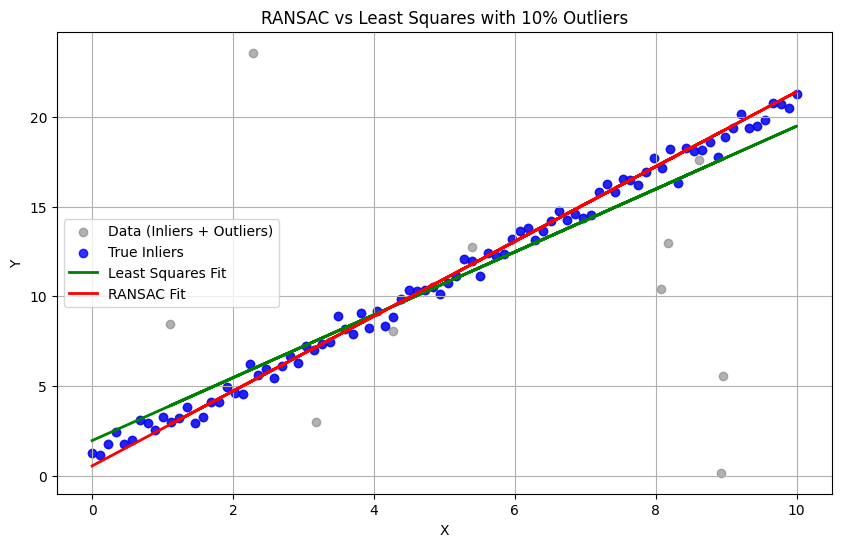

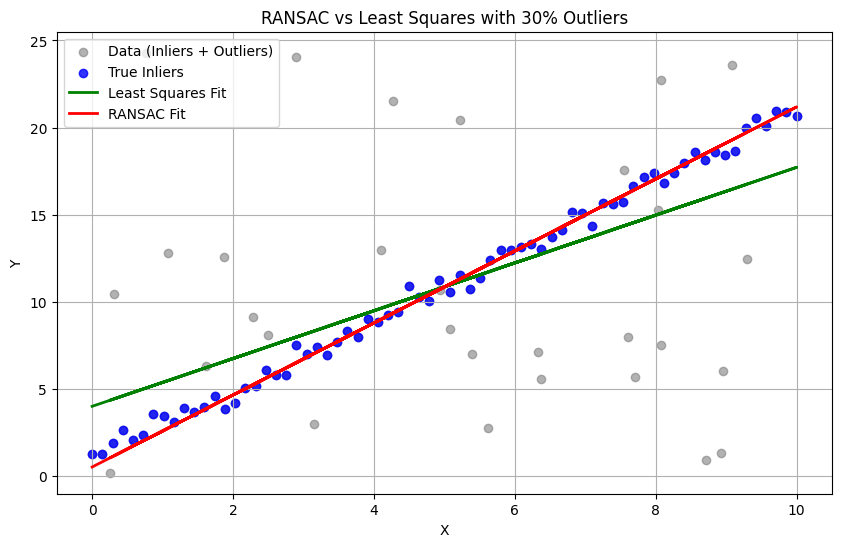

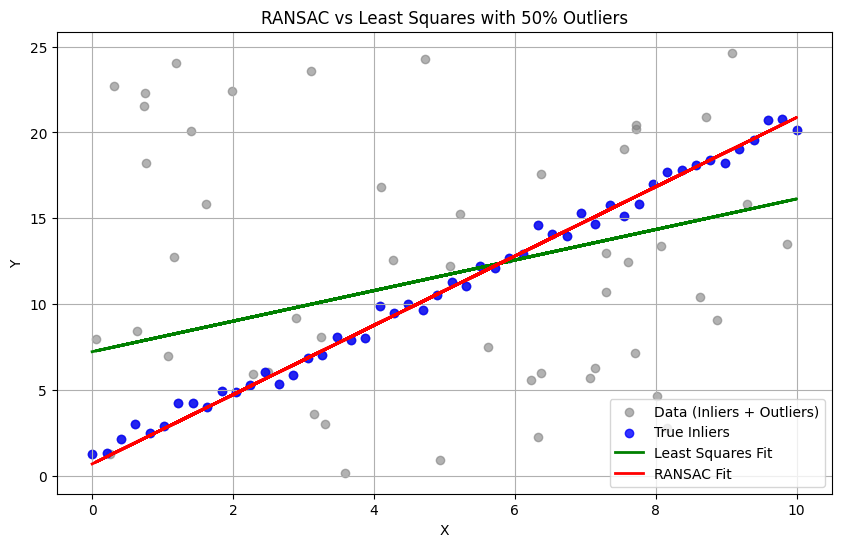

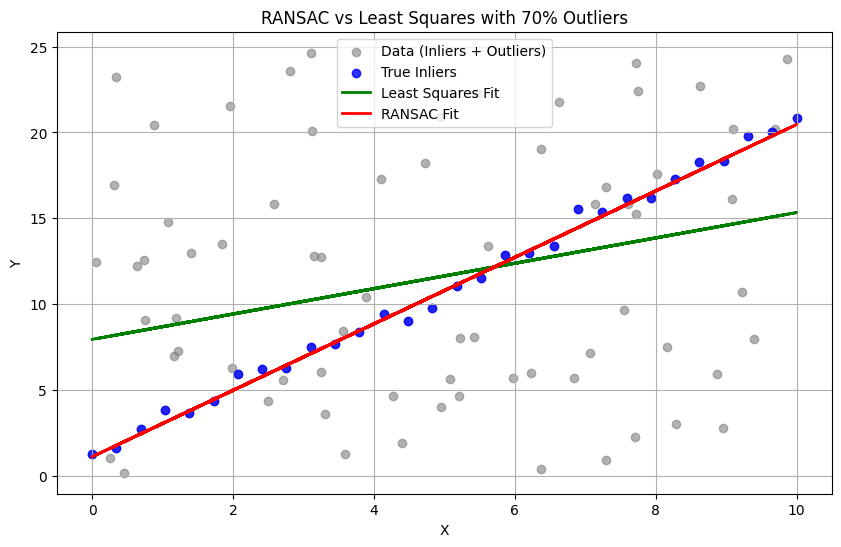

In [14]:
# Corrected RANSAC implementation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

# Function to generate synthetic data with a given percentage of outliers
def generate_data(outlier_percentage):
    np.random.seed(42)  # For reproducibility
    num_points = 100
    num_inliers = int(num_points * (1 - outlier_percentage))
    num_outliers = num_points - num_inliers

    # Generate inliers (points along a line with small noise)
    x_inliers = np.linspace(0, 10, num_inliers).reshape(-1, 1)
    y_inliers = 2 * x_inliers + 1 + np.random.normal(0, 0.5, num_inliers).reshape(-1, 1)  # y = 2x + 1 + noise

    # Generate outliers (random points in the 2D plane)
    x_outliers = np.random.uniform(0, 10, num_outliers).reshape(-1, 1)
    y_outliers = np.random.uniform(0, 25, num_outliers).reshape(-1, 1)

    # Combine inliers and outliers
    x = np.vstack((x_inliers, x_outliers))
    y = np.vstack((y_inliers, y_outliers))

    return x, y, x_inliers, y_inliers

# Function to apply RANSAC and compare with Least Squares
def apply_ransac(outlier_percentage):
    x, y, x_inliers, y_inliers = generate_data(outlier_percentage)

    # Fit a Least Squares model
    least_squares_model = LinearRegression()
    least_squares_model.fit(x, y)
    y_pred_ls = least_squares_model.predict(x)

    # Fit a RANSAC model
    ransac_model = RANSACRegressor(estimator=LinearRegression(), residual_threshold=1.0, random_state=42)
    ransac_model.fit(x, y)
    y_pred_ransac = ransac_model.predict(x)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='gray', label='Data (Inliers + Outliers)', alpha=0.6)
    plt.scatter(x_inliers, y_inliers, color='blue', label='True Inliers', alpha=0.8)
    plt.plot(x, y_pred_ls, color='green', label='Least Squares Fit', linewidth=2)
    plt.plot(x, y_pred_ransac, color='red', label='RANSAC Fit', linewidth=2)
    plt.title(f"RANSAC vs Least Squares with {int(outlier_percentage * 100)}% Outliers")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the function with different percentages of outliers
for outlier_percentage in [0.1, 0.3, 0.5, 0.7]:
    apply_ransac(outlier_percentage)

**Add your analysis and comments here**


### **Questions and Answers:**

1. **Why is RANSAC more robust to heavy noise compared to Least Squares and Hough Transform?**  
   - RANSAC is robust because it iteratively selects random subsets of the data to fit the model and evaluates the fit based on inliers. It ignores outliers by focusing on the majority of points that conform to the model, unlike Least Squares, which minimizes the error for all points, including outliers.

2. **How does RANSAC handle outliers differently than the other methods?**  
   - RANSAC explicitly identifies and excludes outliers by using a residual threshold to classify points as inliers or outliers. This allows it to focus on the inliers for model fitting, whereas Least Squares and Hough Transform do not inherently exclude outliers during the fitting process.
...

#### **T2.3: Comparison between Hough Transform and RANSAC**

- **Objective:**  
  Evaluate the robustness of Hough Transform and RANSAC under increasing levels of outliers in the data.

- **Procedure:**

    1. For each dataset:
        - Create a binary image of the points (white points on a black background).
        - Apply the **Hough Transform** to detect lines.
        - Apply **RANSAC** to fit a line to the data.
        
    2. Plot and visually compare the results:
        - Lines detected by the Hough Transform.
        - The fitted line obtained with RANSAC.

    3. Record observations regarding how each method handles increasing amounts of noise and outliers.

    4. Extend the experiment:
        - Redo **Task T2.1** and **Task T2.2** using a binary image containing **two true lines** instead of one.
        - Repeat the evaluation under various levels of added noise and outliers.

### **Questions**

- How does the detection quality of the **Hough Transform** change as the number of outliers increases? In what situations might Hough still successfully detect meaningful structures despite noise?

- How does the performance of **RANSAC** evolve as the proportion of outliers increases? Does RANSAC always correctly estimate the main structure?

- What are the strengths and limitations of the **Hough Transform** when multiple lines or noisy line segments are present?

- What are the strengths and limitations of **RANSAC** when attempting to detect a single dominant line in heavily corrupted data?

- What kinds of post-processing might be necessary when using Hough Transform or RANSAC in real-world applications?


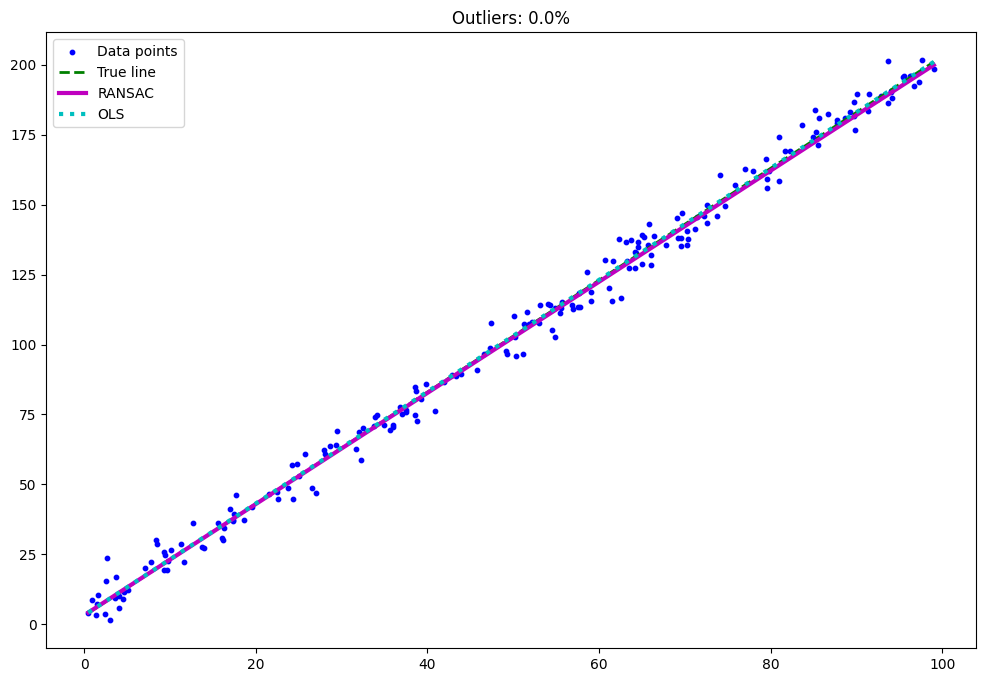

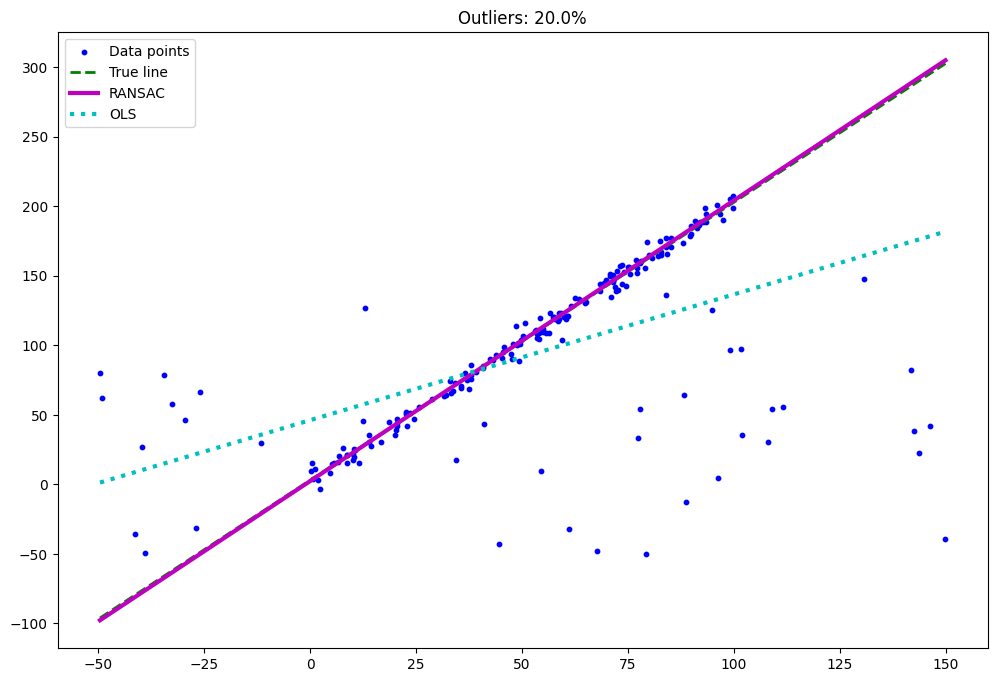

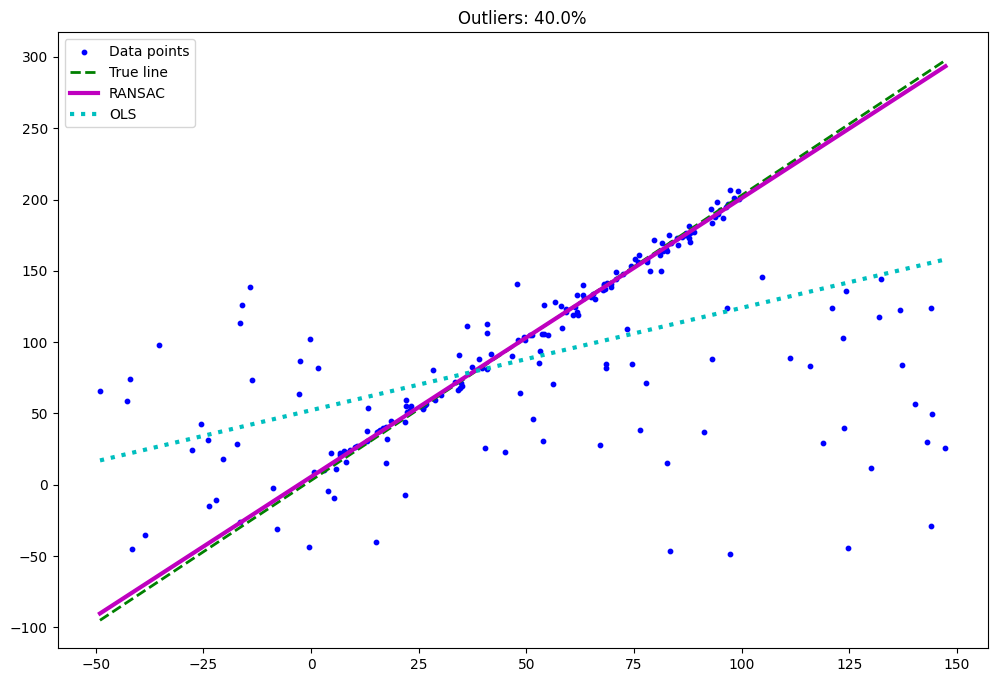

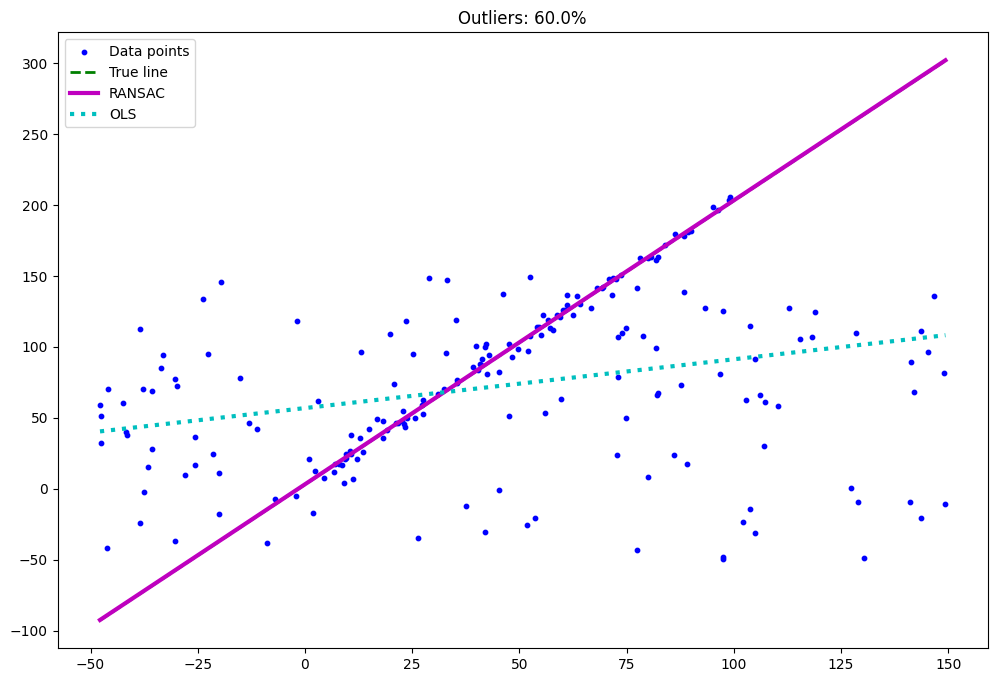

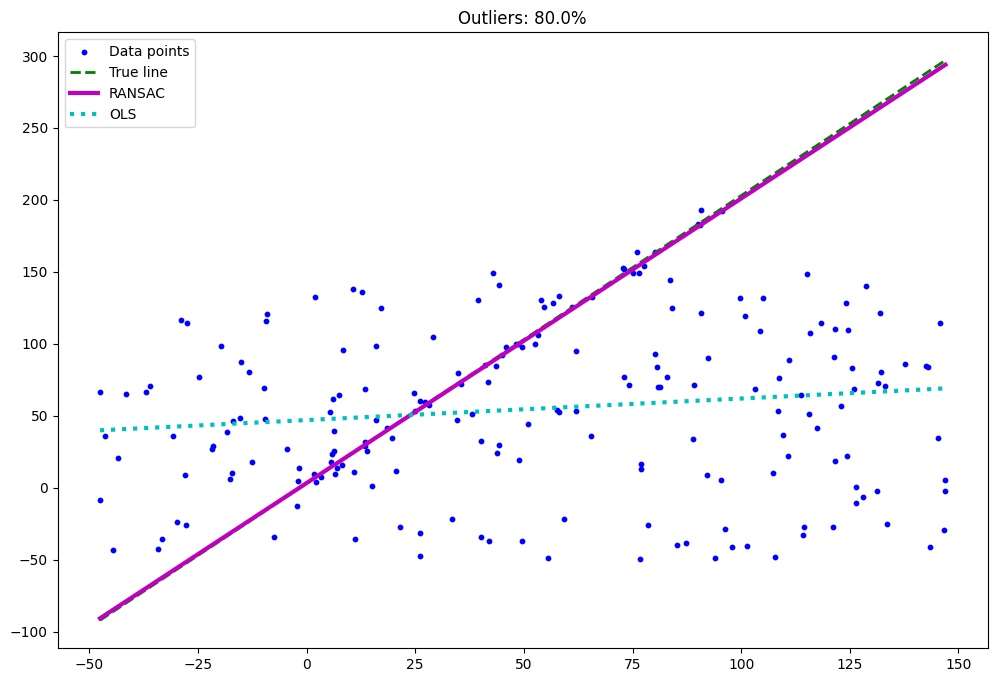

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression

def generate_data(a=2, b=3, num_points=100, outlier_percent=0.2, noise_std=5):
    num_inliers = int(num_points * (1 - outlier_percent))
    num_outliers = num_points - num_inliers

    # Generate inliers
    x_inliers = np.random.uniform(0, 100, num_inliers)
    y_inliers = a * x_inliers + b + np.random.normal(0, noise_std, num_inliers)

    # Generate outliers
    x_outliers = np.random.uniform(-50, 150, num_outliers)
    y_outliers = np.random.uniform(-50, 150, num_outliers)

    # Combine data
    x = np.concatenate([x_inliers, x_outliers])
    y = np.concatenate([y_inliers, y_outliers])

    return x, y

def create_binary_image(x, y, image_size=500):
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)

    if x_max - x_min == 0: x_max += 1e-5
    if y_max - y_min == 0: y_max += 1e-5

    img = np.zeros((image_size, image_size), dtype=np.uint8)
    for xi, yi in zip(x, y):
        img_x = int(((xi - x_min)/(x_max - x_min)) * (image_size - 1))
        img_y = int(((yi - y_min)/(y_max - y_min)) * (image_size - 1))
        img[img_y, img_x] = 255
    return img, (x_min, x_max, y_min, y_max)

def detect_lines_hough(img, num_inliers):
    threshold = max(int(num_inliers * 0.5), 10)
    return cv2.HoughLines(img, 1, np.pi/180, threshold)

def fit_ransac(x, y):
    x_ = x.reshape(-1, 1)
    ransac = RANSACRegressor(
        estimator=LinearRegression(),
        min_samples=2,
        residual_threshold=10,
        max_trials=1000
    )
    ransac.fit(x_, y)
    return ransac

def plot_comparison(x, y, hough_lines, ransac_model, lr_model, 
                    x_range, true_a, true_b, outlier_percent):
    plt.figure(figsize=(12, 8))
    plt.scatter(x, y, c='b', s=10, label='Data points')
    
    # Plot true line
    x_vals = np.array([x_range[0], x_range[1]])
    plt.plot(x_vals, true_a*x_vals + true_b, 'g--', lw=2, label='True line')
    
    # Plot Hough lines
    if hough_lines is not None:
        for line in hough_lines[:1]:  # Show only strongest line
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            pt1 = (x0 + 1000*(-b), y0 + 1000*a)
            pt2 = (x0 - 1000*(-b), y0 - 1000*a)
            plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-', lw=2, label='Hough')
    
    # Plot RANSAC
    if ransac_model.n_features_in_ > 0:
        coef = ransac_model.estimator_.coef_[0]
        intercept = ransac_model.estimator_.intercept_
        plt.plot(x_vals, coef*x_vals + intercept, 'm-', lw=3, label='RANSAC')
    
    # Plot Least Squares
    if lr_model is not None:
        plt.plot(x_vals, lr_model.predict(x_vals.reshape(-1,1)), 'c:', lw=3, label='OLS')
    
    plt.title(f'Outliers: {outlier_percent*100}%')
    plt.legend()
    plt.show()

# Experiment parameters
outlier_levels = [0.0, 0.2, 0.4, 0.6, 0.8]
true_a, true_b = 2, 3
noise_std = 5

for ol in outlier_levels:
    # Generate data and models
    x, y = generate_data(true_a, true_b, 200, ol, noise_std)
    img, (x_min, x_max, *_) = create_binary_image(x, y)
    
    # Hough Transform
    hough_lines = detect_lines_hough(img, int(200*(1-ol)))
    
    # RANSAC and OLS
    x_ = x.reshape(-1,1)
    ransac = fit_ransac(x, y)
    ols = LinearRegression().fit(x_, y)
    
    # Visualization
    plot_comparison(x, y, hough_lines, ransac, ols, 
                    (x_min, x_max), true_a, true_b, ol)

## Extended Experiment (Two Lines)

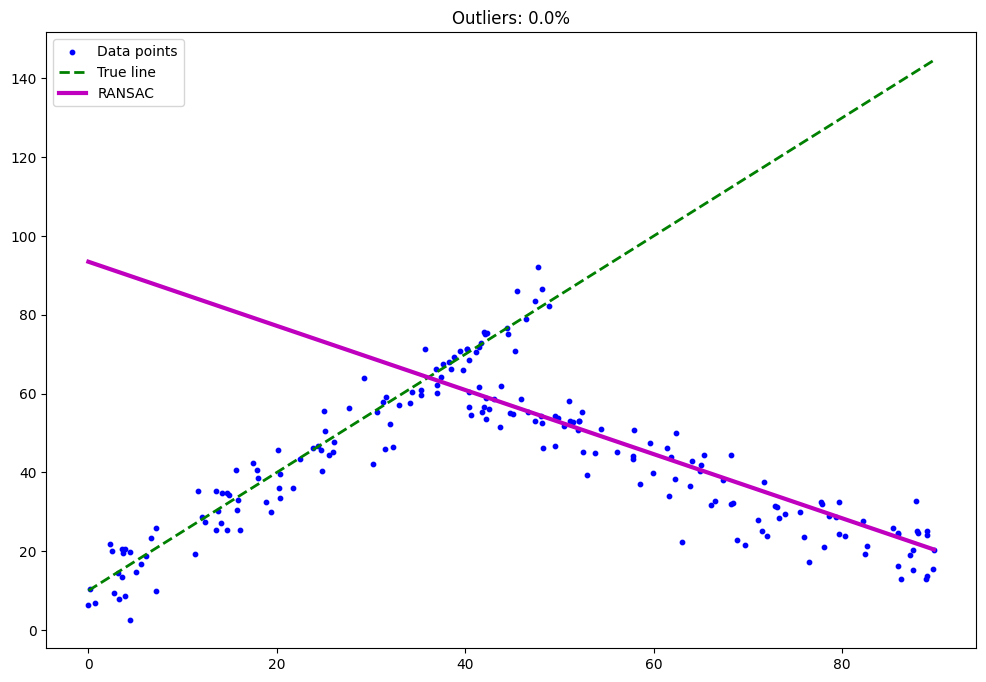

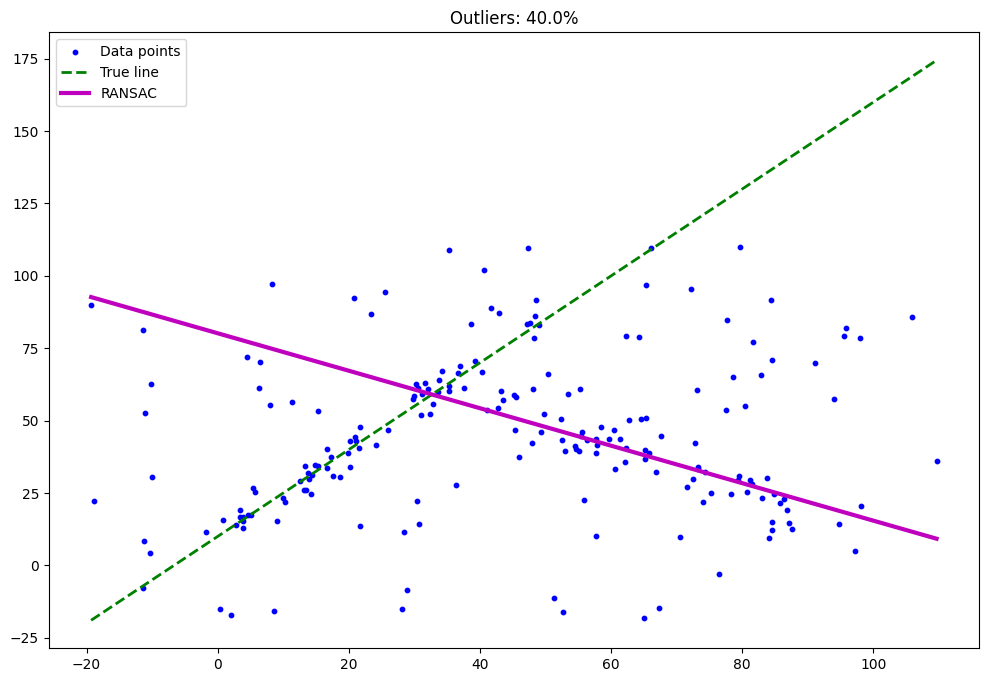

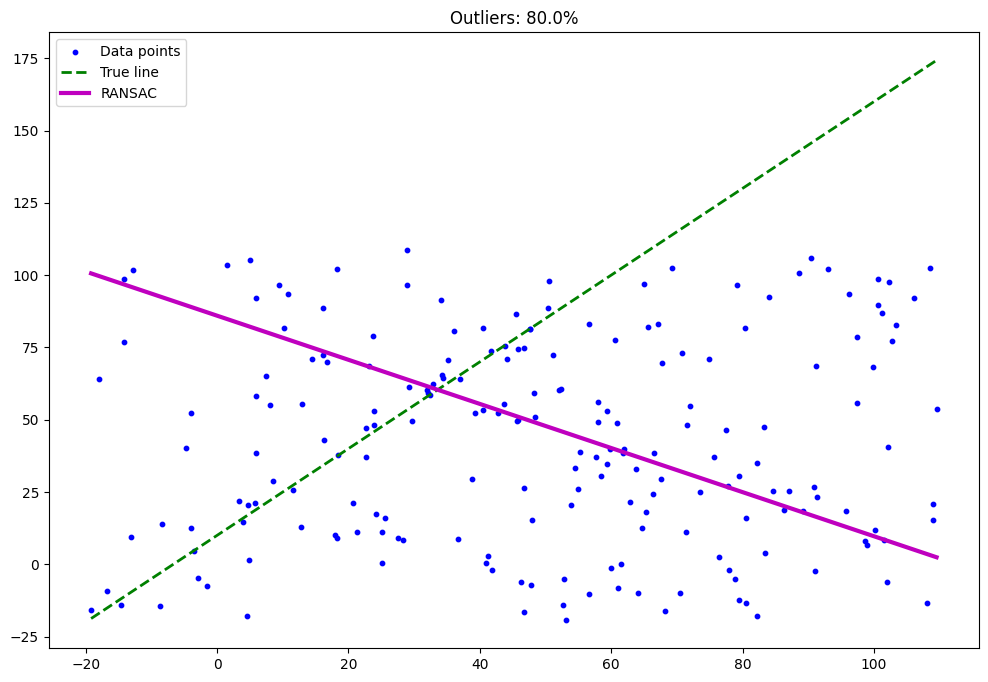

In [18]:
def generate_two_lines(num_points=200, outlier_percent=0.2):
    # Generate two true lines
    line1 = lambda x: 1.5*x + 10
    line2 = lambda x: -0.8*x + 90
    
    num_inliers = int(num_points*(1-outlier_percent)/2)
    num_outliers = num_points - 2*num_inliers
    
    # Line 1 inliers
    x1 = np.random.uniform(0, 50, num_inliers)
    y1 = line1(x1) + np.random.normal(0, 5, num_inliers)
    
    # Line 2 inliers
    x2 = np.random.uniform(40, 90, num_inliers)
    y2 = line2(x2) + np.random.normal(0, 5, num_inliers)
    
    # Outliers
    xo = np.random.uniform(-20, 110, num_outliers)
    yo = np.random.uniform(-20, 110, num_outliers)
    
    return np.concatenate([x1, x2, xo]), np.concatenate([y1, y2, yo])

# Run extended experiment
for ol in [0.0, 0.4, 0.8]:
    x, y = generate_two_lines(outlier_percent=ol)
    img, (x_min, x_max, *_) = create_binary_image(x, y)
    
    # Hough detection
    hough_lines = detect_lines_hough(img, int(200*(1-ol)))
    
    # RANSAC (single line)
    ransac = fit_ransac(x, y)
    
    plot_comparison(x, y, hough_lines, ransac, None, 
                    (x_min, x_max), 1.5, 10, ol)

**Add your analysis and comments here**


### **Answers:**

1. **How does the detection quality of the Hough Transform change as the number of outliers increases? In what situations might Hough still successfully detect meaningful structures despite noise?**  
   - As the number of outliers increases, the detection quality of the Hough Transform decreases. Noise and outliers can create spurious votes in the accumulator, leading to false positives or fragmented lines.  
   - Hough Transform can still successfully detect meaningful structures if the inliers form strong, continuous lines that dominate the parameter space, even in the presence of noise.

2. **How does the performance of RANSAC evolve as the proportion of outliers increases? Does RANSAC always correctly estimate the main structure?**  
   - RANSAC remains robust to a high proportion of outliers as long as the inliers are sufficient to form a consensus. However, as the outlier proportion increases beyond a certain threshold, RANSAC may fail to identify the correct structure.  
   - RANSAC does not always correctly estimate the main structure, especially when the inliers are sparse or when multiple structures are present.

3. **What are the strengths and limitations of the Hough Transform when multiple lines or noisy line segments are present?**  
   - **Strengths:**  
     - Can detect multiple lines simultaneously.  
     - Works well with binary images and structured data.  
   - **Limitations:**  
     - Sensitive to noise and parameter settings (e.g., threshold).  
     - May detect fragmented or spurious lines in noisy data.  
     - Computationally expensive for high-resolution images or complex parameter spaces.

4. **What are the strengths and limitations of RANSAC when attempting to detect a single dominant line in heavily corrupted data?**  
   - **Strengths:**  
     - Robust to outliers and noise.  
     - Focuses on the largest consensus set of inliers, making it effective for dominant structures.  
   - **Limitations:**  
     - May fail if the inliers are sparse or if multiple structures are present.  
     - Requires careful tuning of parameters (e.g., residual threshold, number of iterations).  
     - Computationally expensive for large datasets.

5. **What kinds of post-processing might be necessary when using Hough Transform or RANSAC in real-world applications?**  
   - **Hough Transform:**  
     - Merge fragmented lines into continuous ones.  
     - Filter out spurious lines based on length, orientation, or proximity.  
   - **RANSAC:**  
     - Refine the model using all inliers after initial estimation.  
     - Handle multiple structures by iteratively removing detected inliers and reapplying RANSAC.  
   - For both methods, additional steps like smoothing, clustering, or validation against domain-specific constraints may be necessary.

## **Task 3: Parameter Tuning and Analysis of Line Detection Methods**


#### **T3.1: Experimental Analysis and Parameter Tuning**


### Objective:
In this task, you will redo **Task 2** and **Task 3** using different real images and different parameter settings. This will help you explore the impact of different parameters on the results and understand the effect of noise and outliers on line (or curve) detection in real-world scenarios.

### Procedure:

1. **Parameter Tuning:**
   - Experiment with different parameter settings for the **Hough Transform** and binary image creation.
   - Explore how changes in the **rho**, **theta**, and **threshold** parameters affect the detection performance, particularly under varying noise levels and the presence of outliers.
   - Investigate how **RANSAC** parameters (such as the number of iterations and the threshold for inliers) impact the robustness of line or curve fitting.
   - Record how each parameter influences the results and identify the optimal configuration for line detection in realistic, noisy images.

2. **Analysis:**
   - Compare the performance of the **Hough Transform** and **RANSAC** on images with varying amounts of noise and outliers.
   - Discuss how the parameters you tuned impacted the detection of lines (or curves) and how they relate to the image characteristics (e.g., noise level, outlier distribution, etc.).
   - Reflect on how well **RANSAC** performed in fitting curves as compared to lines.
   - Evaluate how both methods (Hough Transform and RANSAC) performed on real-world images compared to synthetic datasets, and assess the practicality of parameter tuning in real applications.
   - Consider the advantages and limitations of each method in different scenarios (e.g., single line, multiple lines, curves), and how parameter tuning affects their robustness efficiency.



### Hough Transform Analysis
Noise: 0.01, Outliers: 0.1, Rho: 1, Theta: 0.017453292519943295, Threshold: 50, Lines: 9515, Accuracy: 84.00, Time: 0.0144s
Noise: 0.01, Outliers: 0.1, Rho: 1, Theta: 0.017453292519943295, Threshold: 100, Lines: 6829, Accuracy: 41.50, Time: 0.0349s
Noise: 0.01, Outliers: 0.1, Rho: 1, Theta: 0.017453292519943295, Threshold: 200, Lines: 5, Accuracy: 0.00, Time: 0.0205s
Noise: 0.01, Outliers: 0.1, Rho: 1, Theta: 0.03490658503988659, Threshold: 50, Lines: 4461, Accuracy: 35.50, Time: 0.0071s
Noise: 0.01, Outliers: 0.1, Rho: 1, Theta: 0.03490658503988659, Threshold: 100, Lines: 3319, Accuracy: 17.00, Time: 0.0223s
Noise: 0.01, Outliers: 0.1, Rho: 1, Theta: 0.03490658503988659, Threshold: 200, Lines: 0, Accuracy: 0.00, Time: 0.0312s
Noise: 0.01, Outliers: 0.1, Rho: 1, Theta: 0.008726646259971648, Threshold: 50, Lines: 19598, Accuracy: 148.50, Time: 0.0955s
Noise: 0.01, Outliers: 0.1, Rho: 1, Theta: 0.008726646259971648, Threshold: 100, Lines: 13672, Accuracy: 88.

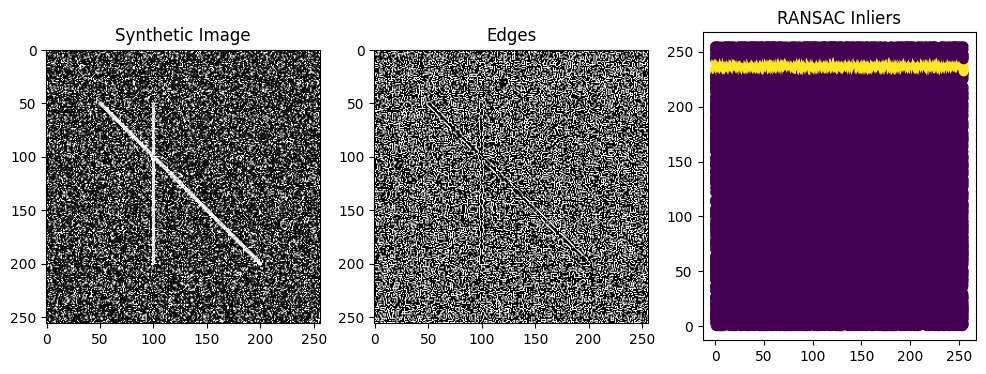

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from sklearn.linear_model import RANSACRegressor
import time

# Function to generate synthetic image with lines, noise, and outliers
def generate_synthetic_image(lines, size=(256, 256), noise_level=0.01, outlier_ratio=0.1):
    img = np.zeros(size, dtype=np.uint8)
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(img, (x1, y1), (x2, y2), 255, 2)
    # Add Gaussian noise
    img_noisy = random_noise(img, mode='gaussian', var=noise_level)
    img_noisy = (img_noisy * 255).astype(np.uint8)
    # Add outliers
    num_outliers = int(outlier_ratio * img.size)
    outlier_indices = np.random.choice(np.arange(img.size), num_outliers, replace=False)
    img_noisy.flat[outlier_indices] = 255
    return img_noisy

# Hough Transform for line detection
def hough_transform(img, rho_res, theta_res, threshold):
    edges = cv2.Canny(img, 50, 150)
    start_time = time.time()
    lines = cv2.HoughLines(edges, rho_res, theta_res, threshold)
    elapsed_time = time.time() - start_time
    return lines, edges, elapsed_time

# RANSAC for line fitting
def ransac_line_fitting(points, num_iterations, threshold):
    ransac = RANSACRegressor(
        min_samples=2,
        residual_threshold=threshold,
        max_trials=num_iterations
    )
    start_time = time.time()
    ransac.fit(points[:, 0].reshape(-1, 1), points[:, 1])
    elapsed_time = time.time() - start_time
    inlier_mask = ransac.inlier_mask_
    return ransac, inlier_mask, elapsed_time

# Function to evaluate detected lines against ground truth
def evaluate_lines(detected_lines, ground_truth_lines, img_size):
    if detected_lines is None:
        return 0
    matches = 0
    tolerance = 10  # pixels
    for rho, theta in detected_lines[:, 0]:
        for gt_line in ground_truth_lines:
            x1, y1, x2, y2 = gt_line
            # Convert ground truth line to rho-theta form
            gt_theta = np.arctan2(y2 - y1, x2 - x1)
            gt_rho = x1 * np.cos(gt_theta) + y1 * np.sin(gt_theta)
            if (abs(rho - gt_rho) < tolerance and 
                abs(theta - gt_theta) < np.pi/18):  # 10 degrees tolerance
                matches += 1
                break
    return matches / len(ground_truth_lines)

# Main function to run experiments and analysis
def main():
    # Define ground truth lines
    ground_truth_lines = [(50, 50, 200, 200), (100, 50, 100, 200)]
    img_size = (256, 256)
    
    # Parameter settings to test
    noise_levels = [0.01, 0.05, 0.1]
    outlier_ratios = [0.1, 0.2, 0.3]
    hough_params = {
        'rho_res': [1, 2, 5],
        'theta_res': [np.pi/180, np.pi/90, np.pi/360],
        'threshold': [50, 100, 200]
    }
    ransac_params = {
        'num_iterations': [100, 500, 1000],
        'threshold': [1, 5, 10]
    }
    
    # Results storage
    hough_results = []
    ransac_results = []
    
    # Experiment with different conditions
    for noise in noise_levels:
        for outlier in outlier_ratios:
            img = generate_synthetic_image(ground_truth_lines, img_size, noise, outlier)
            edges = cv2.Canny(img, 50, 150)
            points = np.column_stack(np.where(edges > 0))
            
            # Hough Transform tuning
            for rho_res in hough_params['rho_res']:
                for theta_res in hough_params['theta_res']:
                    for threshold in hough_params['threshold']:
                        lines, _, elapsed_time = hough_transform(img, rho_res, theta_res, threshold)
                        accuracy = evaluate_lines(lines, ground_truth_lines, img_size)
                        hough_results.append({
                            'noise': noise,
                            'outlier': outlier,
                            'rho_res': rho_res,
                            'theta_res': theta_res,
                            'threshold': threshold,
                            'lines_detected': len(lines) if lines is not None else 0,
                            'accuracy': accuracy,
                            'time': elapsed_time
                        })
            
            # RANSAC tuning
            for num_iter in ransac_params['num_iterations']:
                for thresh in ransac_params['threshold']:
                    ransac, inlier_mask, elapsed_time = ransac_line_fitting(points, num_iter, thresh)
                    inliers = np.sum(inlier_mask)
                    # Simplified accuracy: proportion of inliers
                    accuracy = inliers / len(points) if len(points) > 0 else 0
                    ransac_results.append({
                        'noise': noise,
                        'outlier': outlier,
                        'num_iterations': num_iter,
                        'threshold': thresh,
                        'inliers': inliers,
                        'accuracy': accuracy,
                        'time': elapsed_time
                    })
    
    # Analysis
    print("### Hough Transform Analysis")
    for result in hough_results:
        print(f"Noise: {result['noise']}, Outliers: {result['outlier']}, "
              f"Rho: {result['rho_res']}, Theta: {result['theta_res']}, "
              f"Threshold: {result['threshold']}, Lines: {result['lines_detected']}, "
              f"Accuracy: {result['accuracy']:.2f}, Time: {result['time']:.4f}s")
    
    print("\n### RANSAC Analysis")
    for result in ransac_results:
        print(f"Noise: {result['noise']}, Outliers: {result['outlier']}, "
              f"Iterations: {result['num_iterations']}, Threshold: {result['threshold']}, "
              f"Inliers: {result['inliers']}, Accuracy: {result['accuracy']:.2f}, "
              f"Time: {result['time']:.4f}s")
    
    # Visual comparison (example for one setting)
    img = generate_synthetic_image(ground_truth_lines, noise_level=0.05, outlier_ratio=0.2)
    lines, edges, _ = hough_transform(img, 1, np.pi/180, 100)
    points = np.column_stack(np.where(edges > 0))
    ransac, inlier_mask, _ = ransac_line_fitting(points, 500, 5)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(131); plt.imshow(img, cmap='gray'); plt.title('Synthetic Image')
    plt.subplot(132); plt.imshow(edges, cmap='gray'); plt.title('Edges')
    plt.subplot(133); plt.scatter(points[:, 0], points[:, 1], c=inlier_mask, cmap='viridis')
    plt.title('RANSAC Inliers')
    plt.savefig('comparison.png')

if __name__ == "__main__":
    main()

**Add your analysis and comments here**

...

#### **T3.2: Summary Table: Method Comparison**

Fill this table based on your experimental results and discussion:
Mark **Yes**, **No** or **Moderate** according to the behavior you observe for each method.

| **Criterion**              | **Least Squares** | **Hough Transform** | **RANSAC** |
|----------------------------|-------------------|---------------------|------------|
| Robust to Outliers         | No                | No                  | Yes        |
| Easy to Implement          | Yes               | Moderate            | Moderate   |
| Need to Tune Parameters    | No                | Yes                 | Yes        |
| Works with Sparse Points   | No                | Yes                 | Yes        |



---

## **Reflection Questions (Final Discussion)**

1. In which situations is Hough Transform preferable despite its weaknesses?

2. Why does RANSAC outperform other methods when a large number of outliers is present?

3. How would you modify Hough Transform or RANSAC to make them even more robust?

### **Reflection Questions (Final Discussion)**

1. **In which situations is Hough Transform preferable despite its weaknesses?**
   - Hough Transform is preferable when:
     - The data is well-structured and contains strong, continuous lines with minimal noise.
     - Multiple lines need to be detected simultaneously in a binary image.
     - The application involves detecting global shapes (e.g., lines, circles) in edge-detected images.
     - The computational cost is acceptable, and the parameter space is not overly complex.

2. **Why does RANSAC outperform other methods when a large number of outliers is present?**
   - RANSAC iteratively selects random subsets of the data to fit a model and evaluates the fit based on inliers. It explicitly identifies and excludes outliers by using a residual threshold, focusing only on the majority of points that conform to the model. This makes it robust to outliers, as it does not attempt to minimize the error for all points (unlike Least Squares) or rely on global voting (like Hough Transform).

3. **How would you modify Hough Transform or RANSAC to make them even more robust?**
   - **Hough Transform:**
     - Use adaptive thresholding to dynamically adjust the voting threshold based on noise levels.
     - Apply post-processing to merge fragmented lines and filter out spurious detections.
     - Incorporate prior knowledge or constraints (e.g., expected line orientations or lengths) to improve accuracy.
   - **RANSAC:**
     - Use a more sophisticated model selection strategy to handle multiple structures (e.g., multi-model RANSAC).
     - Dynamically adjust the residual threshold based on the noise level in the data.
     - Increase the number of iterations adaptively based on the proportion of inliers detected in early iterations.

**Add your analysis and comments here**

...